Kaggle Heart Disease [update later]

ATTEMPTED IMPROVED LABELING OF FEATURE SELECTION / LEARNING

Fitting 15 folds for each of 162 candidates, totalling 2430 fits


c:\Users\tenne\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [0.90787982 0.90785542 0.90789671 0.90793989 0.90795866 0.9079549
 0.90789671 0.90789296 0.90792862 0.90786668 0.90796241 0.9080206
 0.90786668 0.90796241 0.9080206  0.90786668 0.90796241 0.9080206
 0.9079474  0.90795303 0.9079549  0.9079474  0.90795303 0.9079549
 0.9079474  0.90795303 0.9079549  0.90639313 0.90698255 0.90699006
 0.90769962 0.90791361 0.90793238 0.90800371 0.90812197 0.90810132
 0.90800934 0.90803374 0.90806002 0.90800934 0.90803374 0.90806002
 0.90800934 0.90803374 0.90806002 0.90801873 0.90805627 0.90806565
 0.90801873 0.90805627 0.90806565 0.90801873 0.90805627 0.90806565
 0.90287163 0.9035474  0.90380082 0.90756634 0.90780473 0.90780474
 0.9079549  0.90800183 0.90806941 0.90804313 0.90801497 0.90798869
 0.90804313 0.90801497 0.90798869 0.90804313 0.90801497 0.90798869
 0.90800934 0.90805064 0.9

Best parameters found:  {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 200}

Feature Importance Rankings:
              Feature  Importance
13            GenHlth    0.175901
18                Age    0.161080
5              Stroke    0.095653
0              HighBP    0.082856
16           DiffWalk    0.074401
1            HighChol    0.067423
17                Sex    0.053494
15           PhysHlth    0.052670
3                 BMI    0.049392
6            Diabetes    0.040420
20             Income    0.040161
4              Smoker    0.026208
14           MentHlth    0.022762
19          Education    0.021083
8              Fruits    0.010951
7        PhysActivity    0.010365
9             Veggies    0.007583
12        NoDocbcCost    0.003517
10  HvyAlcoholConsump    0.001849
11      AnyHealthcare    0.001408
2           CholCheck    0.000822


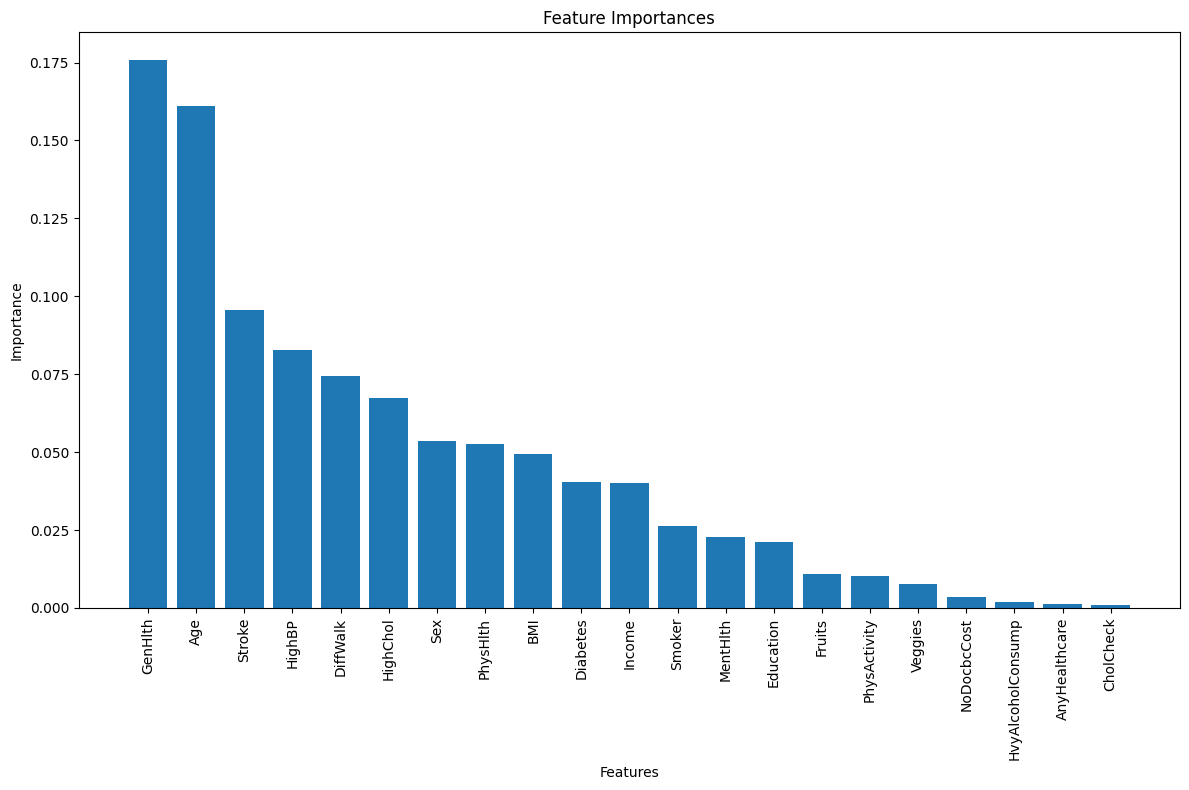

OSError: [Errno 22] Invalid argument: 'feature_importances.csv'

In [3]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn.exceptions import FitFailedWarning

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FitFailedWarning)

# Load the dataset
file_path = "G:/My Drive/research/predator/11-30-2024-predator-8.4/heart_disease_health_indicators_BRFSS2015.csv"
data = pd.read_csv(file_path)

# Assuming that the first column is the target and the rest are features
X = data.iloc[:, 1:]  # Features
y = data.iloc[:, 0]   # Target (diagnosis)

# Split data into training and testing sets (70% training, 30% testing) with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale the data (optional for Random Forest, but generally good practice)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Custom scoring function to maximize correlation
def correlation_scorer(estimator, X, y):
    y_pred_proba = estimator.predict_proba(X)[:, 1]
    correlation, _ = pearsonr(y_pred_proba, y)
    return correlation

# Set up the RandomForestClassifier with out-of-bag scoring enabled and parallel processing
rf = RandomForestClassifier(random_state=42, oob_score=True, n_jobs=-1, verbose=1)

# Define a refined grid of hyperparameters to search over for best accuracy and correlation
param_grid = {
    'n_estimators': [50, 100, 200],  # Range of trees
    'max_depth': [10, 20, None],  # Depths
    'min_samples_split': [2, 10, 20],  # Splits
    'min_samples_leaf': [1, 10, 20],  # Leaf nodes
    'bootstrap': [True, False]  # Bootstrapping
}

# Use Repeated Stratified K-Fold for robust cross-validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# Use multiple metrics for evaluation
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'auc': 'roc_auc',
    'correlation': correlation_scorer
}

# Perform grid search with multi-metric evaluation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    refit='correlation',  # Refit the model based on the best correlation found
    n_jobs=-1,
    verbose=1
)

# Fit the model with GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Use the best model to make predictions on the test set
best_rf_model = grid_search.best_estimator_

# Extract and rank feature importances
feature_importances = best_rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print the ranked feature importance table
print("\nFeature Importance Rankings:")
print(feature_importance_df)

# Visualize feature importances
indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=90)  # Use feature names as labels
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

# Optionally save the feature importances to a CSV file for analysis
output_file = "feature_importances.csv"
feature_importance_df.to_csv(output_file, index=False)
print(f"\nFeature importances saved to {output_file}")

# Compute the predicted probabilities for correlation calculation
y_pred_proba = best_rf_model.predict_proba(X_test_scaled)[:, 1]

# Compute Pearson correlation between predicted probabilities and actual target values
correlation, _ = pearsonr(y_pred_proba, y_test)
print(f"Maximal Correlation: {correlation:.4f}")

# Make predictions (binary classification) on the test set
y_pred = best_rf_model.predict(X_test_scaled)

# Calculate and print detailed performance metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate and print accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc_score = roc_auc_score(y_test, y_pred_proba)

# Print the performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {auc_score:.4f}")


INDIVIDUAL DIAGNOSIS + CONFIDENCE

In [18]:
import numpy as np
import pandas as pd

# Assuming scaler and best_rf_model are already trained and available from previous code

# New patient measurements (formatted as a 1D array)
# Added three placeholders for the missing values: you must replace 'NaN' with actual values if known
new_patient_data = np.array([57, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0])  # Adjust these 'NaN'

# Convert to DataFrame with feature names (assuming feature names from the training set)
feature_names = X.columns  # Use the feature names from the training set
new_patient_df = pd.DataFrame([new_patient_data], columns=feature_names)

# Handle missing values if any ('NaN' should be replaced or handled appropriately)
# new_patient_df.fillna(method='ffill', inplace=True)  # Example: forward fill

# Scale the new patient data
new_patient_data_scaled = scaler.transform(new_patient_df)

# Make a prediction and get the confidence score
prediction = best_rf_model.predict(new_patient_data_scaled)[0]  # Predicted class (0 or 1)
confidence_score = best_rf_model.predict_proba(new_patient_data_scaled)[0][prediction]  # Confidence for the predicted class

# Display the results
print(f"Prediction for the patient: {prediction}")
print(f"Confidence score: {confidence_score:.4f}")


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Prediction for the patient: 1
Confidence score: 1.0000


STATISTICS ON CONFIDENCE FOR ALL DATA (MEAN/SD OF CONFIDENCES and CORRECTNESS STATS as a %)

In [4]:
# Scale the data (optional)
X_scaled = scaler.fit_transform(X)
best_rf_model.fit(X_scaled, y)

# Predict probabilities for the entire dataset
full_pred_prob = best_rf_model.predict_proba(X_scaled)

# Extract the maximum predicted probability for each sample to represent the model's confidence
max_confidences = np.max(full_pred_prob, axis=1)

# Calculate the mean and standard deviation of these confidences
mean_confidence = np.mean(max_confidences)
std_dev_confidence = np.std(max_confidences)

# Make predictions (most probable class)
full_predictions = np.argmax(full_pred_prob, axis=1)

# Ensure y is numeric or properly factorized
if not np.issubdtype(y.dtype, np.number):
    actual_classes = y.factorize()[0]
else:
    actual_classes = y

# Check for label consistency
print("Unique values in full_predictions:", np.unique(full_predictions))
print("Unique values in y (before any factorization):", np.unique(y))
print("Unique values in actual_classes (after factorization if applied):", np.unique(actual_classes))

# Correct for any label mapping, if necessary
if np.unique(full_predictions).size != np.unique(actual_classes).size:
    label_map = {label: idx for idx, label in enumerate(np.unique(y))}
    actual_classes = np.array([label_map[val] for val in y])

# Ensure both arrays are integers and have the same shape
full_predictions = full_predictions.astype(int).ravel()
actual_classes = np.array(actual_classes).astype(int).ravel()

# Calculate correctness
correct_predictions = (full_predictions == actual_classes)
correctness_percent = np.mean(correct_predictions) * 100

# Display results
print("Full Predictions:", full_predictions)
print("Actual Classes:", actual_classes)
print("Shapes - Full Predictions:", full_predictions.shape, "Actual Classes:", actual_classes.shape)

# Print the computed statistics
print(f"Mean Confidence: {mean_confidence:.4f}")
print(f"Standard Deviation of Confidence: {std_dev_confidence:.4f}")
print(f"Correctness Percentage: {correctness_percent:.2f}%")



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   28.2s finished


Unique values in full_predictions: [0 1]
Unique values in y (before any factorization): [0. 1.]
Unique values in actual_classes (after factorization if applied): [0. 1.]
Full Predictions: [0 0 0 ... 0 0 0]
Actual Classes: [0 0 0 ... 0 0 1]
Shapes - Full Predictions: (253680,) Actual Classes: (253680,)
Mean Confidence: 0.9070
Standard Deviation of Confidence: 0.1110
Correctness Percentage: 91.02%


INDIVIDUAL

In [2]:
# Assuming scaler and best_rf_model are already trained and available from previous code

# New patient measurements (formatted as a 1D array)
# Added three placeholders for the missing values: you must replace 'NaN' with actual values if known
new_patient_data = np.array([12.88, 28.92, 82.5, 514.3, 0.08123, 0.05824, 0.06195, 0.02343, 0.1566, 0.05708, 
                             0.2116, 1.36, 1.502, 16.83, 0.008412, 0.02153, 0.03898, 0.00762, 0.01695, 0.002801, 
                             13.89, 35.74, 88.84, 595.7, 0.1227, 0.162, 0.2439, 'NaN', 'NaN', 'NaN'])  # Adjust these 'NaN'

# Convert to DataFrame with feature names (assuming feature names from the training set)
feature_names = X.columns  # Use the feature names from the training set
new_patient_df = pd.DataFrame([new_patient_data], columns=feature_names)

# Handle missing values if any ('NaN' should be replaced or handled appropriately)
# new_patient_df.fillna(method='ffill', inplace=True)  # Example: forward fill

# Scale the new patient data
new_patient_data_scaled = scaler.transform(new_patient_df)

# Make a prediction and get the confidence score
prediction = best_rf_model.predict(new_patient_data_scaled)[0]  # Predicted class (0 or 1)
confidence_score = best_rf_model.predict_proba(new_patient_data_scaled)[0][prediction]  # Confidence for the predicted class

# Display the results
print(f"Prediction for the patient: {prediction}")
print(f"Confidence score: {confidence_score:.4f}")

Prediction for the patient: 0
Confidence score: 0.9400


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
